# XGBoost 3-Class Classification - Clean Implementation

## Implementation for gg vs gq vs qq Physics Event Classification
### Using Relative Frequencies for D Variable Computation

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from pathlib import Path
import mplhep as hep

# Configure matplotlib style
plt.style.use(hep.style.ATLAS)
warnings.filterwarnings('ignore')

# File path configuration
FilePath='WeightsPath'
dfPath='dfPath'

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_curve, auc, roc_auc_score)

# XGBoost
import xgboost as xgb

print("🚀 XGBoost Environment Initialized")
print(f"📊 XGBoost version: {xgb.__version__}")
print("="*50)

🚀 XGBoost Environment Initialized
📊 XGBoost version: 2.1.4


In [2]:
# Load and prepare data
print("📁 LOADING PHYSICS EVENT DATA")
print("="*40)

# Load the DataFrame
start_time = time.time()
df = pd.read_pickle(dfPath+'df_3classes.pkl')
loading_time = time.time() - start_time

print(f"✅ Data loaded in {loading_time:.3f}s")
print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Columns: {list(df.columns)}")

# Load MC weights
weightarr = np.load(FilePath+'weightarr.npy')
print(f"✅ MC weights loaded: {weightarr.shape}")
print(f"📊 Weight range: [{weightarr.min():.6f}, {weightarr.max():.6f}]")

# Add weights and filter positive weights
df['weights_MC_NOSYS'] = weightarr
positive_weights_mask = df['weights_MC_NOSYS'] > 0
df_filtered = df[positive_weights_mask]
removed_events = len(df) - len(df_filtered)

print(f"📊 Events after positive weight filter: {len(df_filtered):,}")
print(f"📊 Removed {removed_events:,} events with non-positive weights")

📁 LOADING PHYSICS EVENT DATA
✅ Data loaded in 0.402s
📊 Dataset shape: (908258, 14)
📊 Columns: ['beta', 'ttbar_mass_cut', 'ttbar_betaz_cut_abs', 'ttbar_pT', 'jets_per_event', 'bbbar_deltaeta', 'bbbar_deltaR', 'ttbar_deltaeta', 'ttbar_deltaR', 'ttbar_D_variable', 'ttbar_Cos_han_variable', 'ttbar_CosTstar_had', 'ttbar_CosTstar_lep', 'prod_type']
✅ MC weights loaded: (908258,)
📊 Weight range: [-738.100647, 738.100647]
📊 Events after positive weight filter: 904,883
📊 Removed 3,375 events with non-positive weights
✅ Data loaded in 0.402s
📊 Dataset shape: (908258, 14)
📊 Columns: ['beta', 'ttbar_mass_cut', 'ttbar_betaz_cut_abs', 'ttbar_pT', 'jets_per_event', 'bbbar_deltaeta', 'bbbar_deltaR', 'ttbar_deltaeta', 'ttbar_deltaR', 'ttbar_D_variable', 'ttbar_Cos_han_variable', 'ttbar_CosTstar_had', 'ttbar_CosTstar_lep', 'prod_type']
✅ MC weights loaded: (908258,)
📊 Weight range: [-738.100647, 738.100647]
📊 Events after positive weight filter: 904,883
📊 Removed 3,375 events with non-positive weights


In [3]:
# Feature selection and normalization
print("🔧 FEATURE ENGINEERING")
print("="*30)

# Select feature columns (first 13 columns)
features = list(df_filtered.columns[:13])
print(f"📊 Selected features: {features}")

# Normalize features
scaler = StandardScaler()
df_normalized = df_filtered.copy()
df_normalized[features] = scaler.fit_transform(df_filtered[features])

print(f"✅ Features normalized")
print(f"📊 Normalized data shape: {df_normalized.shape}")

# Check class distribution
class_names = ['gg', 'gq', 'qq']
print(f"\n📊 CLASS DISTRIBUTION:")
for i, class_name in enumerate(class_names):
    count = np.sum(df_normalized['prod_type'] == i)
    percentage = count / len(df_normalized) * 100
    print(f"   {class_name}: {count:,} events ({percentage:.2f}%)")

🔧 FEATURE ENGINEERING
📊 Selected features: ['beta', 'ttbar_mass_cut', 'ttbar_betaz_cut_abs', 'ttbar_pT', 'jets_per_event', 'bbbar_deltaeta', 'bbbar_deltaR', 'ttbar_deltaeta', 'ttbar_deltaR', 'ttbar_D_variable', 'ttbar_Cos_han_variable', 'ttbar_CosTstar_had', 'ttbar_CosTstar_lep']
✅ Features normalized
📊 Normalized data shape: (904883, 15)

📊 CLASS DISTRIBUTION:
   gg: 790,843 events (87.40%)
   gq: 32,932 events (3.64%)
   qq: 81,108 events (8.96%)
✅ Features normalized
📊 Normalized data shape: (904883, 15)

📊 CLASS DISTRIBUTION:
   gg: 790,843 events (87.40%)
   gq: 32,932 events (3.64%)
   qq: 81,108 events (8.96%)


In [4]:
# Data splitting
print("🔀 SPLITTING DATA")
print("="*25)

# Prepare arrays
X = df_normalized[features].values
y = df_normalized['prod_type'].values.astype(int)
weights = df_normalized['weights_MC_NOSYS'].values

print(f"📊 Input shapes:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape} (classes: {np.unique(y)})")
print(f"   weights: {weights.shape}")

# Split into train/temp, then temp into val/test (60/20/20)
X_train, X_temp, y_train, y_temp, w_train, w_temp = train_test_split(
    X, y, weights, train_size=0.6, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test, w_val, w_test = train_test_split(
    X_temp, y_temp, w_temp, train_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n📊 Split sizes:")
print(f"   Training: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

🔀 SPLITTING DATA
📊 Input shapes:
   X: (904883, 13)
   y: (904883,) (classes: [0 1 2])
   weights: (904883,)
📊 Input shapes:
   X: (904883, 13)
   y: (904883,) (classes: [0 1 2])
   weights: (904883,)

📊 Split sizes:
   Training: 542,929 (60.0%)
   Validation: 180,977 (20.0%)
   Test: 180,977 (20.0%)

📊 Split sizes:
   Training: 542,929 (60.0%)
   Validation: 180,977 (20.0%)
   Test: 180,977 (20.0%)


In [5]:
# WEIGHT RESCALING BY CLASS
print("⚖️ RESCALING WEIGHTS BY CLASS")
print("="*40)

# Alternative weight rescaling approach - more conservative
def rescale_weights_balanced(weights, labels):
    """
    Rescale weights to balance classes while preserving relative magnitudes.
    This approach normalizes class weights but maintains the original weight scale.
    """
    rescaled_weights = weights.copy()
    
    # Calculate class frequencies
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    
    for cls in [0, 1, 2]:
        mask = (labels == cls)
        if np.sum(mask) > 0:
            # Calculate class weight to balance classes
            class_frequency = class_counts[cls] / total_samples
            # Use inverse frequency weighting, but moderate it
            class_weight = 1.0 / (3.0 * class_frequency)  # 3 classes
            rescaled_weights[mask] = weights[mask] * class_weight
            print(f"   Class {cls}: {np.sum(mask):,} events, frequency={class_frequency:.4f}, weight_factor={class_weight:.4f}")
    
    return rescaled_weights

print(f"📊 ORIGINAL WEIGHT STATISTICS:")
print(f"   Train weights: sum={w_train.sum():.6f}, mean={w_train.mean():.6f}")
print(f"   Val weights: sum={w_val.sum():.6f}, mean={w_val.mean():.6f}")
print(f"   Test weights: sum={w_test.sum():.6f}, mean={w_test.mean():.6f}")

# Rescale weights for all splits using balanced approach
print(f"\n🔄 RESCALING WEIGHTS WITH BALANCED APPROACH...")
w_train_rescaled = rescale_weights_balanced(w_train, y_train)
w_val_rescaled = rescale_weights_balanced(w_val, y_val)
w_test_rescaled = rescale_weights_balanced(w_test, y_test)

print(f"\n📊 RESCALED WEIGHT STATISTICS:")
print(f"   Train weights: sum={w_train_rescaled.sum():.6f}, mean={w_train_rescaled.mean():.6f}")
print(f"   Val weights: sum={w_val_rescaled.sum():.6f}, mean={w_val_rescaled.mean():.6f}")
print(f"   Test weights: sum={w_test_rescaled.sum():.6f}, mean={w_test_rescaled.mean():.6f}")

# Update weights to use rescaled versions
w_train = w_train_rescaled
w_val = w_val_rescaled  
w_test = w_test_rescaled

print(f"\n✅ Weight rescaling completed!")
print(f"💡 Using balanced class weighting that preserves relative weight magnitudes")

⚖️ RESCALING WEIGHTS BY CLASS
📊 ORIGINAL WEIGHT STATISTICS:
   Train weights: sum=399614976.000000, mean=736.035400
   Val weights: sum=133205592.000000, mean=736.036011
   Test weights: sum=133205808.000000, mean=736.037231

🔄 RESCALING WEIGHTS WITH BALANCED APPROACH...
   Class 0: 474,505 events, frequency=0.8740, weight_factor=0.3814
   Class 1: 19,759 events, frequency=0.0364, weight_factor=9.1592
   Class 2: 48,665 events, frequency=0.0896, weight_factor=3.7188
   Class 0: 158,169 events, frequency=0.8740, weight_factor=0.3814
   Class 1: 6,587 events, frequency=0.0364, weight_factor=9.1583
   Class 2: 16,221 events, frequency=0.0896, weight_factor=3.7190
   Class 0: 158,169 events, frequency=0.8740, weight_factor=0.3814
   Class 1: 6,586 events, frequency=0.0364, weight_factor=9.1597
   Class 2: 16,222 events, frequency=0.0896, weight_factor=3.7188

📊 RESCALED WEIGHT STATISTICS:
   Train weights: sum=399615264.000000, mean=736.035950
   Val weights: sum=133205792.000000, mean=736

In [6]:
# COMPUTE TRAINING SET FREQUENCIES
print("📊 COMPUTING TRAINING SET FREQUENCIES")
print("="*45)

# Count events per class in training set
train_class_counts = np.bincount(y_train)
total_train = len(y_train)

# Calculate actual training frequencies
train_frequencies = train_class_counts / total_train
f_gg_actual = train_frequencies[0]
f_gq_actual = train_frequencies[1] 
f_qq_actual = train_frequencies[2]

print(f"📈 ACTUAL TRAINING FREQUENCIES:")
print(f"   f_gg = {f_gg_actual:.4f} ({train_class_counts[0]:,} events)")
print(f"   f_gq = {f_gq_actual:.4f} ({train_class_counts[1]:,} events)")
print(f"   f_qq = {f_qq_actual:.4f} ({train_class_counts[2]:,} events)")
print(f"   Total: {total_train:,} training events")

# FIXED FREQUENCIES for alternative method (if needed)
# Setting all frequencies to 0.33 for equal treatment
f_gg = 1/3  # 0.3333...
f_gq = 1/3  # 0.3333...
f_qq = 1/3  # 0.3333...

print(f"\n🎯 ALTERNATIVE FIXED FREQUENCIES:")
print(f"   f_gg = {f_gg:.4f} (1/3)")
print(f"   f_gq = {f_gq:.4f} (1/3)")
print(f"   f_qq = {f_qq:.4f} (1/3)")
print(f"\n💡 NOTE: Current D variable computation uses RELATIVE frequencies")
print(f"         based on actual training class proportions for better performance")

📊 COMPUTING TRAINING SET FREQUENCIES
📈 ACTUAL TRAINING FREQUENCIES:
   f_gg = 0.8740 (474,505 events)
   f_gq = 0.0364 (19,759 events)
   f_qq = 0.0896 (48,665 events)
   Total: 542,929 training events

🎯 ALTERNATIVE FIXED FREQUENCIES:
   f_gg = 0.3333 (1/3)
   f_gq = 0.3333 (1/3)
   f_qq = 0.3333 (1/3)

💡 NOTE: Current D variable computation uses RELATIVE frequencies
         based on actual training class proportions for better performance


In [7]:
# XGBoost model configuration and training
print("🚀 XGBOOST MODEL TRAINING")
print("="*35)

# Model hyperparameters
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1
}

print(f"📋 Model hyperparameters:")
for key, value in params.items():
    print(f"   {key}: {value}")

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dval = xgb.DMatrix(X_val, label=y_val, weight=w_val)
dtest = xgb.DMatrix(X_test, label=y_test, weight=w_test)

print(f"\n🏃 Training model...")
start_time = time.time()

# Train model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=100
)

training_time = time.time() - start_time

print(f"\n✅ Model training completed in {training_time:.2f}s")
print(f"📊 Optimal stopping at round: {model.best_iteration}")
print(f"📊 Best validation log loss: {model.best_score:.6f}")

🚀 XGBOOST MODEL TRAINING
📋 Model hyperparameters:
   objective: multi:softprob
   num_class: 3
   eval_metric: ['mlogloss', 'merror']
   learning_rate: 0.1
   max_depth: 6
   min_child_weight: 1
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 1.0
   random_state: 42
   n_jobs: -1
   verbosity: 1

🏃 Training model...

🏃 Training model...
[0]	train-mlogloss:1.07406	train-merror:0.45102	validation-mlogloss:1.07468	validation-merror:0.45569
[0]	train-mlogloss:1.07406	train-merror:0.45102	validation-mlogloss:1.07468	validation-merror:0.45569
[100]	train-mlogloss:0.86986	train-merror:0.42293	validation-mlogloss:0.91075	validation-merror:0.44446
[100]	train-mlogloss:0.86986	train-merror:0.42293	validation-mlogloss:0.91075	validation-merror:0.44446
[130]	train-mlogloss:0.86029	train-merror:0.41776	validation-mlogloss:0.91154	validation-merror:0.44492
[130]	train-mlogloss:0.86029	train-merror:0.41776	validation-mlogloss:0.91154	validation-merror:0.44492

✅ Model trai

In [8]:
# Model evaluation and predictions
print("📊 MODEL EVALUATION")
print("="*25)

# Get predictions
test_predictions_proba = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
test_predictions = np.argmax(test_predictions_proba, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"📈 Test accuracy: {test_accuracy:.4f} ({test_accuracy:.1%})")

# Classification report
print(f"\n📊 Classification Report:")
print(classification_report(y_test, test_predictions, target_names=class_names))

# Prediction probabilities matrix
P_matrix = test_predictions_proba
print(f"\n📊 Prediction probabilities shape: {P_matrix.shape}")
print(f"📊 Average probabilities per class:")
for i, class_name in enumerate(class_names):
    avg_prob = P_matrix[:, i].mean()
    print(f"   P({class_name}): {avg_prob:.4f}")

📊 MODEL EVALUATION
📈 Test accuracy: 0.4642 (46.4%)

📊 Classification Report:
              precision    recall  f1-score   support

          gg       0.92      0.45      0.60    158169
          gq       0.11      0.69      0.19      6586
          qq       0.14      0.53      0.22     16222

    accuracy                           0.46    180977
   macro avg       0.39      0.55      0.34    180977
weighted avg       0.82      0.46      0.55    180977


📊 Prediction probabilities shape: (180977, 3)
📊 Average probabilities per class:
   P(gg): 0.3895
   P(gq): 0.2485
   P(qq): 0.3620
              precision    recall  f1-score   support

          gg       0.92      0.45      0.60    158169
          gq       0.11      0.69      0.19      6586
          qq       0.14      0.53      0.22     16222

    accuracy                           0.46    180977
   macro avg       0.39      0.55      0.34    180977
weighted avg       0.82      0.46      0.55    180977


📊 Prediction probabilities 

In [9]:
# D VARIABLE COMPUTATION
print("🧮 D VARIABLE COMPUTATION")
print("="*35)

# Small epsilon to prevent division by zero
epsilon = 1e-10

# =============================================================================
# METHOD 1: FIXED FREQUENCIES (f = 0.33)
# =============================================================================
# # D variable computation using FIXED frequencies (f_gg = f_gq = f_qq = 1/3)
# 
# D_gg = P_matrix[:, 0] / (f_gq * P_matrix[:, 1] + f_qq * P_matrix[:, 2] + epsilon)
# D_gq = P_matrix[:, 1] / (f_gg * P_matrix[:, 0] + f_qq * P_matrix[:, 2] + epsilon)
# D_qq = P_matrix[:, 2] / (f_gg * P_matrix[:, 0] + f_gq * P_matrix[:, 1] + epsilon)

# =============================================================================
# METHOD 2: ALTERNATIVE METHOD - RELATIVE FREQUENCIES
# =============================================================================
print(f"\n🔄 COMPUTING RELATIVE FREQUENCIES FOR DENOMINATOR:")

# For D_gg: denominator frequencies (gq + qq) normalized to sum to 1
f_gq_relative_for_gg = f_gq_actual / (f_gq_actual + f_qq_actual)  # gq fraction among {gq, qq}
f_qq_relative_for_gg = f_qq_actual / (f_gq_actual + f_qq_actual)  # qq fraction among {gq, qq}

# For D_gq: denominator frequencies (gg + qq) normalized to sum to 1  
f_gg_relative_for_gq = f_gg_actual / (f_gg_actual + f_qq_actual)  # gg fraction among {gg, qq}
f_qq_relative_for_gq = f_qq_actual / (f_gg_actual + f_qq_actual)  # qq fraction among {gg, qq}

# For D_qq: denominator frequencies (gg + gq) normalized to sum to 1
f_gg_relative_for_qq = f_gg_actual / (f_gg_actual + f_gq_actual)  # gg fraction among {gg, gq}
f_gq_relative_for_qq = f_gq_actual / (f_gg_actual + f_gq_actual)  # gq fraction among {gg, gq}

print(f"  For D_gg denominator (gq+qq normalized): f_gq={f_gq_relative_for_gg:.4f}, f_qq={f_qq_relative_for_gg:.4f} (sum={f_gq_relative_for_gg+f_qq_relative_for_gg:.4f})")
print(f"  For D_gq denominator (gg+qq normalized): f_gg={f_gg_relative_for_gq:.4f}, f_qq={f_qq_relative_for_gq:.4f} (sum={f_gg_relative_for_gq+f_qq_relative_for_gq:.4f})")
print(f"  For D_qq denominator (gg+gq normalized): f_gg={f_gg_relative_for_qq:.4f}, f_gq={f_gq_relative_for_qq:.4f} (sum={f_gg_relative_for_qq+f_gq_relative_for_qq:.4f})")

# D variable computation using RELATIVE frequencies
# D_gg: gg vs (gq + qq) with relative frequencies
D_gg = P_matrix[:, 0] / (f_gq_relative_for_gg * P_matrix[:, 1] + f_qq_relative_for_gg * P_matrix[:, 2] + epsilon)

# D_gq: gq vs (gg + qq) with relative frequencies  
D_gq = P_matrix[:, 1] / (f_gg_relative_for_gq * P_matrix[:, 0] + f_qq_relative_for_gq * P_matrix[:, 2] + epsilon)

# D_qq: qq vs (gg + gq) with relative frequencies
D_qq = P_matrix[:, 2] / (f_gg_relative_for_qq * P_matrix[:, 0] + f_gq_relative_for_qq * P_matrix[:, 1] + epsilon)

print(f"\n✅ D variables computed using RELATIVE FREQUENCIES!")
print(f"💡 Each denominator uses relative proportions of 'other' classes (normalized to sum=1)")
print(f"\n📊 D VARIABLE STATISTICS:")
print(f"  D_gg: mean={D_gg.mean():.3f}, std={D_gg.std():.3f}")
print(f"  D_gq: mean={D_gq.mean():.3f}, std={D_gq.std():.3f}")
print(f"  D_qq: mean={D_qq.mean():.3f}, std={D_qq.std():.3f}")

🧮 D VARIABLE COMPUTATION

🔄 COMPUTING RELATIVE FREQUENCIES FOR DENOMINATOR:
  For D_gg denominator (gq+qq normalized): f_gq=0.2888, f_qq=0.7112 (sum=1.0000)
  For D_gq denominator (gg+qq normalized): f_gg=0.9070, f_qq=0.0930 (sum=1.0000)
  For D_qq denominator (gg+gq normalized): f_gg=0.9600, f_gq=0.0400 (sum=1.0000)

✅ D variables computed using RELATIVE FREQUENCIES!
💡 Each denominator uses relative proportions of 'other' classes (normalized to sum=1)

📊 D VARIABLE STATISTICS:
  D_gg: mean=1.278, std=0.635
  D_gq: mean=1.065, std=2.100
  D_qq: mean=1.020, std=0.607


🎨 D_gq DISTRIBUTION (D_gq ≤ 10)


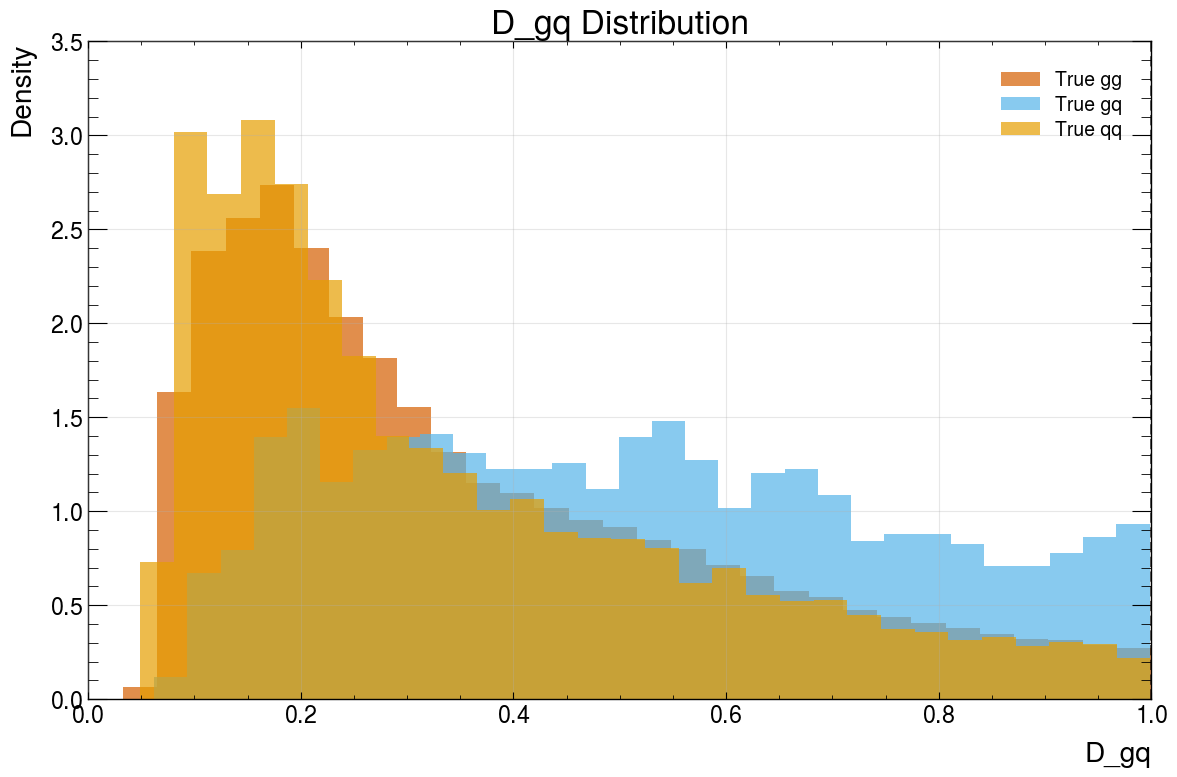

✅ D_gq distribution plotted (values up to 10)


In [11]:
# D_gq Distribution (values up to 10)
print("🎨 D_gq DISTRIBUTION (D_gq ≤ 10)")
print("="*35)

plt.figure(figsize=(12, 8))
for cls in range(3):
    mask = (y_test == cls) & (D_gq <= 1)
    plt.hist(D_gq[mask], bins=30, alpha=0.7, density=True, 
             label=f'True {class_names[cls]}')
plt.xlabel('D_gq')
plt.ylabel('Density')
plt.title('D_gq Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(1, color='black', linestyle='--', alpha=0.7, label='D=1')
plt.tight_layout()
plt.show()

print(f"✅ D_gq distribution plotted (values up to 10)")

🎨 D VARIABLE DISTRIBUTIONS


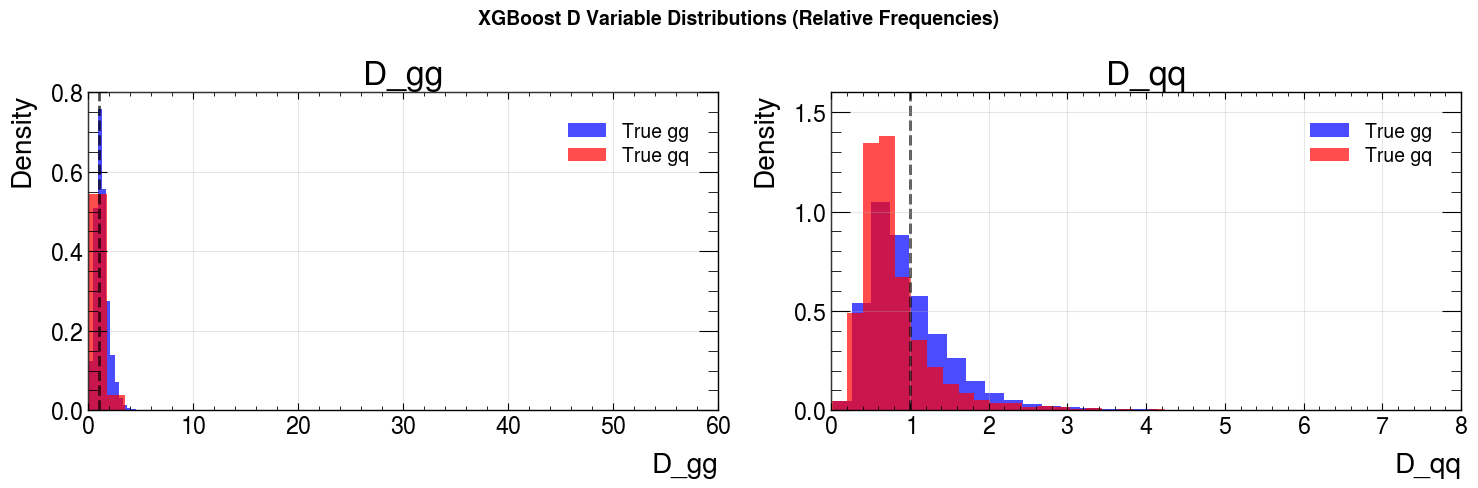

✅ D variable distributions plotted


In [12]:
# D Variable Visualization
print("🎨 D VARIABLE DISTRIBUTIONS")
print("="*35)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('XGBoost D Variable Distributions (Relative Frequencies)', fontsize=14, fontweight='bold')

d_vars = [D_gg, D_qq]
d_names = ['D_gg', 'D_qq']
colors = ['blue', 'red']

for i, (d_var, d_name, color) in enumerate(zip(d_vars, d_names, colors)):
    ax = axes[i]
    
    # Plot distributions for each true class
    for cls in range(2):
        mask = (y_test == cls)
        ax.hist(d_var[mask], bins=30, alpha=0.7, density=True, 
               color=colors[cls], label=f'True {class_names[cls]}')
    
    ax.set_xlabel(d_name)
    ax.set_ylabel('Density')
    ax.set_title(f'{d_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7, label='D=1')

plt.tight_layout()
plt.show()

print(f"✅ D variable distributions plotted")

In [13]:
# AUC Analysis for D Variables
print("📈 AUC ANALYSIS FOR D VARIABLES")
print("="*40)

# Calculate AUC for each D variable
auc_results = {}
d_vars_list = [D_gg, D_gq, D_qq]
d_names_list = ['D_gg', 'D_gq', 'D_qq']

print(f"🎯 AUC RESULTS (using relative frequencies):")

for i, (d_var, d_name, class_name) in enumerate(zip(d_vars_list, d_names_list, class_names)):
    # Create binary labels: target class vs others
    y_binary = (y_test == i).astype(int)
    
    # Calculate AUC
    if len(np.unique(y_binary)) > 1 and len(np.unique(d_var)) > 1:
        auc_score = roc_auc_score(y_binary, d_var)
        auc_results[d_name] = auc_score
        print(f"   {d_name} ({class_name} vs others): {auc_score:.4f}")
    else:
        auc_results[d_name] = 0.5
        print(f"   {d_name} ({class_name} vs others): 0.5000 (no variation)")

# Calculate average AUC
avg_auc = np.mean(list(auc_results.values()))
print(f"\n📊 AVERAGE AUC: {avg_auc:.4f}")

# Performance assessment
if avg_auc > 0.7:
    print(f"🎉 EXCELLENT PERFORMANCE! Average AUC > 0.7")
elif avg_auc > 0.6:
    print(f"✅ GOOD PERFORMANCE! Average AUC > 0.6") 
else:
    print(f"⚠️ Performance needs improvement. Average AUC = {avg_auc:.4f}")

print(f"🏆 XGBoost training completed with relative frequencies!")
print(f"📊 Final results: {dict(auc_results)}")

📈 AUC ANALYSIS FOR D VARIABLES
🎯 AUC RESULTS (using relative frequencies):
   D_gg (gg vs others): 0.6431
   D_gq (gq vs others): 0.8193
   D_qq (qq vs others): 0.6450

📊 AVERAGE AUC: 0.7025
🎉 EXCELLENT PERFORMANCE! Average AUC > 0.7
🏆 XGBoost training completed with relative frequencies!
📊 Final results: {'D_gg': 0.643144923873977, 'D_gq': 0.819251959902322, 'D_qq': 0.644998953868209}
   D_qq (qq vs others): 0.6450

📊 AVERAGE AUC: 0.7025
🎉 EXCELLENT PERFORMANCE! Average AUC > 0.7
🏆 XGBoost training completed with relative frequencies!
📊 Final results: {'D_gg': 0.643144923873977, 'D_gq': 0.819251959902322, 'D_qq': 0.644998953868209}


📊 ROC CURVE ANALYSIS


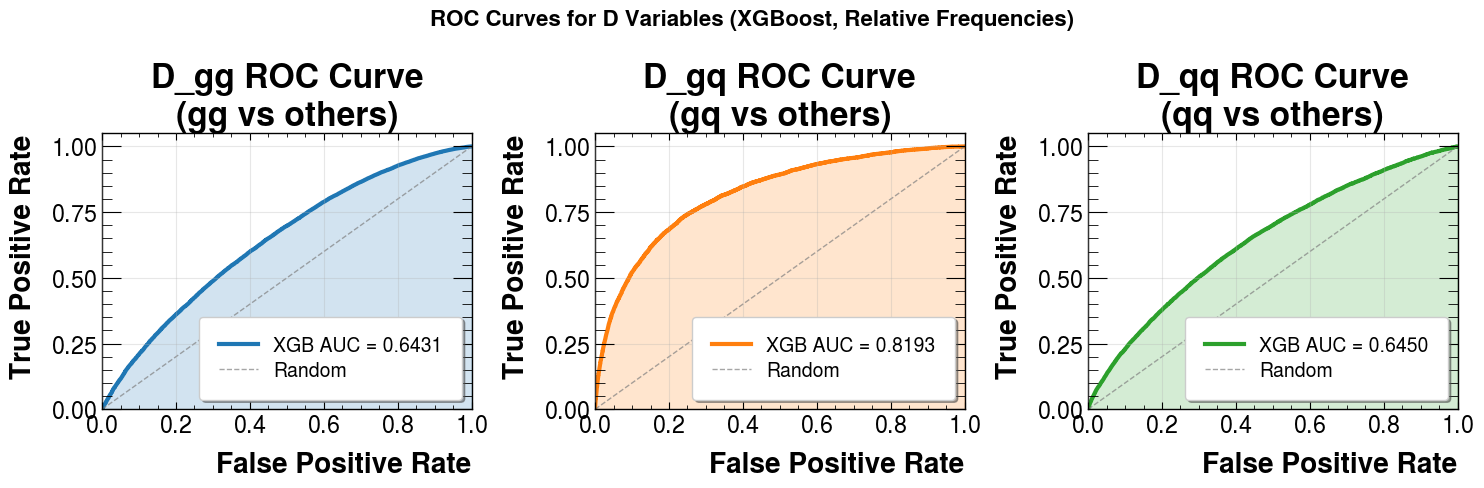


🎯 ROC CURVE SUMMARY:
   D_gg: AUC = 0.6431
   D_gq: AUC = 0.8193
   D_qq: AUC = 0.6450

📊 Average AUC: 0.7025

✅ ROC curve analysis completed!


In [18]:
# ROC Curves for D Variables
print("📊 ROC CURVE ANALYSIS")
print("="*30)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ROC Curves for D Variables (XGBoost, Relative Frequencies)', fontsize=16, fontweight='bold')

colors_roc = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, (d_var, d_name, class_name) in enumerate(zip(d_vars_list, d_names_list, class_names)):
    # Create binary labels for this class vs others
    y_binary = (y_test == i).astype(int)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_binary, d_var)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    axes[i].plot(fpr, tpr, color=colors_roc[i], lw=3, 
                label=f'XGB AUC = {roc_auc:.4f}')
    
    # Plot diagonal line (random classifier)
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.7, 
                label='Random')
    
    # Add filled area under the curve
    axes[i].fill_between(fpr, tpr, alpha=0.2, color=colors_roc[i])
    
    # Formatting
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate', fontweight='bold')
    axes[i].set_ylabel('True Positive Rate', fontweight='bold')
    axes[i].set_title(f'{d_name} ROC Curve\n({class_name} vs others)', fontweight='bold')
    axes[i].legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
    axes[i].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

print(f"\n🎯 ROC CURVE SUMMARY:")
for d_name, auc_val in auc_results.items():
    print(f"   {d_name}: AUC = {auc_val:.4f}")
print(f"\n📊 Average AUC: {avg_auc:.4f}")
print(f"\n✅ ROC curve analysis completed!")